## Importing Packages

In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

import numpy as np
import pandas as pd
import cmdstanpy 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import json
from utils.random import random_rdm_2A
from utils.utils import get_dfs, calculate_waic, bci, plot_mean_posterior
import ipywidgets as widgets

In [2]:
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["pdf.use14corefonts"] = True

## Choose Model

#### roots and global variables

In [3]:
root = "../"
plots_root = "Results/hierarchical/Plots/"
datasets_root = root + "Datasets/"
behavioural_data_root = datasets_root +  "behavioral_data/selected_data/" 
stan_files_root = root +  "models/stan/" 
saved_models_root = "Results/hierarchical/stan_results/"

model_config = {}
plots_path = ""
dataset_path = ""
stan_file_path = ""
stan_output_dir = ""

#### read models configuration json file

In [4]:
with open("../models/rdm_based_models.json") as f:
    models = json.load(f)
    models_name = list(models.keys())

#### Choose and set model configuration

In [5]:
def SetModelAndPaths(model_name):
    global model_config
    global plots_path
    global dataset_path
    global stan_file_path
    global stan_output_dir
    model_config = models[model_name]
    plots_path = plots_root + model_config["plots_folder_name"] + "/"
    dataset_path = datasets_root + "AI Models Results/" + model_config["dataset_name"]
    stan_file_path = stan_files_root + model_config["stan_file"]
    stan_output_dir = saved_models_root + model_config["model_name"] + "/"
    
    if not os.path.exists(plots_path):
        os.makedirs(plots_path)
        print("Directory " , plots_path ,  " Created ")
    else:    
        print("Directory " , plots_path ,  " already exists")
        
    if not os.path.exists(stan_output_dir):
        os.makedirs(stan_output_dir)
        print("Directory " , stan_output_dir ,  " Created ")
    else:    
        print("Directory " , stan_output_dir ,  " already exists")

widgets.interact(SetModelAndPaths, model_name=models_name);

interactive(children=(Dropdown(description='model_name', options=('RDM_cd', 'RDM_ndm', 'ANN-RDM_l_FT', 'ANN-RD…

In [6]:
model_config

{'model_name': 'RDM_cd',
 'stan_file': 'RDM/RDM_cd.stan',
 'dataset_name': 'fastText_FC.csv',
 'plots_folder_name': 'RDM_cd',
 'transf_params': ['transf_mu_drift_word',
  'transf_mu_drift_nonword',
  'transf_mu_threshold_word',
  'transf_mu_threshold_nonword',
  'transf_mu_ndt']}

## Prepare data

Loading words and non-words with zipf and predicted probabilities

In [7]:
word_nword_df = pd.read_csv(dataset_path, header=None,
                            names =["string", "freq",  "label", "zipf",
                                    "category", "word_prob", "non_word_prob"])
word_nword_df

,string,freq,label,zipf,category,word_prob,non_word_prob
0,Ipe's,0,0,0.000000,NW,6.484266e-08,9.999998e-01
1,toothcamb,0,0,0.000000,NW,4.641062e-05,9.999536e-01
2,flicks,702,1,2.935287,LF,9.993498e-01,6.502719e-04
3,Samoar,0,0,0.000000,NW,1.966545e-06,9.999980e-01
4,lastened,0,0,0.000000,NW,1.107923e-04,9.998892e-01
...,...,...,...,...,...,...,...
74312,drased,0,0,0.000000,NW,6.662523e-05,9.999334e-01
74313,exorcism,238,1,3.274105,HF,9.999999e-01,7.543648e-08
74314,pobs,0,0,0.000000,NW,1.563252e-07,9.999999e-01
74315,undemonstrative,3,1,1.592864,LF,9.999452e-01,5.486609e-05


In [8]:
# Reading LDT Data
behavioural_df = pd.read_csv(behavioural_data_root + "LDT_data.csv",
                             header=None,
                             names=["accuracy", "rt", "string", "response",
                                    "participant", "minRT", "participant_id"])
# Merging  behavioral dataframe with word_nonword_df to have words and non-words data with behavioral data
behavioural_df = pd.merge(behavioural_df, word_nword_df, on="string", how="left").dropna().reset_index(drop=True)
behavioural_df = behavioural_df.drop(["freq", "participant"], axis=1)

In [9]:
behavioural_df.head()

,accuracy,rt,string,response,minRT,participant_id,label,zipf,category,word_prob,non_word_prob
0,1,0.422,sand,1,0.422,1,1.0,4.307194,HF,0.999509,0.000491
1,1,0.462,textbook,1,0.422,1,1.0,3.344913,HF,0.999996,0.000003
2,0,0.490,carmed,1,0.422,1,0.0,0.000000,NW,0.000087,0.999913
3,1,0.503,pain,1,0.422,1,1.0,4.990457,HF,0.999988,0.000012
4,1,0.513,technical,1,0.422,1,1.0,3.916116,HF,0.999640,0.000360


In [10]:
# Reducing size of dataframe for testing purposes
behavioural_df = behavioural_df.loc[behavioural_df["participant_id"].isin(np.arange(5))]

In [11]:
behavioural_df

,accuracy,rt,string,response,minRT,participant_id,label,zipf,category,word_prob,non_word_prob
0,1,0.422,sand,1,0.422,1,1.0,4.307194,HF,0.999509,0.000491
1,1,0.462,textbook,1,0.422,1,1.0,3.344913,HF,0.999996,0.000003
2,0,0.490,carmed,1,0.422,1,0.0,0.000000,NW,0.000087,0.999913
3,1,0.503,pain,1,0.422,1,1.0,4.990457,HF,0.999988,0.000012
4,1,0.513,technical,1,0.422,1,1.0,3.916116,HF,0.999640,0.000360
...,...,...,...,...,...,...,...,...,...,...,...
1462,1,1.360,hippo,1,0.294,4,1.0,3.155157,HF,0.999901,0.000099
1463,1,1.398,moneybubs,0,0.294,4,0.0,0.000000,NW,0.001611,0.998389
1464,0,1.419,brining,1,0.294,4,0.0,0.000000,NW,0.878061,0.121939
1465,1,1.430,expectable,1,0.294,4,1.0,1.592864,LF,0.999925,0.000075


## Stan Model and Estimation

Compiling stan model

In [12]:
rdm_model = cmdstanpy.CmdStanModel(model_name=model_config["model_name"],
                                   stan_file=stan_file_path)

20:57:43 - cmdstanpy - INFO - compiling stan file E:\Workspace\Thesis\ANN-EAM\models\stan\RDM\RDM_cd.stan to exe file E:\Workspace\Thesis\ANN-EAM\models\stan\RDM\RDM_cd.exe
20:58:17 - cmdstanpy - INFO - compiled model executable: E:\Workspace\Thesis\ANN-EAM\models\stan\RDM\RDM_cd.exe
20:58:17 - cmdstanpy - WARNING - Stan compiler has produced 19 warnings:
20:58:17 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=E:/Workspace/Thesis/ANN-EAM/models/stan/RDM/RDM_cd.hpp E:/Workspace/Thesis/ANN-EAM/models/stan/RDM/RDM_cd.stan
Warning in 'E:/Workspace/Thesis/ANN-EAM/models/stan/RDM/RDM_cd.stan', line 54, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'E:/Workspace/Thesis/ANN-EAM/models/stan/RDM/RDM_cd.stan', line 55, column 4: Declaratio

Preparing model"s inputs

note that some inputs of data_dict might not be used depending on which model is used

In [13]:
N = len(behavioural_df)                                                    # For all models
participant = behavioural_df["participant_id"].to_numpy()                     # For all models
p = behavioural_df.loc[:, ["word_prob", "non_word_prob"]].to_numpy()       # predicted probabilites of words and non-words, for ANN-EAM models
frequency = behavioural_df["zipf"].to_numpy().astype(int)                  # zipf values, for models with non-decision time or drift modulation
frequencyCondition = behavioural_df["category"].replace(["HF", "LF", "NW"], [1, 2, 3]).to_numpy() # For models with conditional drift
response = behavioural_df["response"].to_numpy().astype(int)               # for all models
rt = behavioural_df["rt"].to_numpy()                                       # for all models
minRT = behavioural_df["minRT"].to_numpy()                                 # for all models
RTbound = 0.1                                                              # for all models
Number_Of_Participants = len(set(behavioural_df["participant_id"]))

threshold_priors = [2, 1, 1, 1]          # For all models with LBA
ndt_priors = [0, 0.5, 1, 1];               # For models wtihout non-decision time modulation
g_priors = [-2, 1, 0, 1]                 # For models wtih non-decision time modulation
m_priors = [0, 0.5, 0, 1]                # For models wtih non-decision time modulation
drift_priors = [1, 2, 1, 1]              # For models without drift mapping functions (non ANN-EAM models)
alpha_priors = [0, 1, 1, 1]              # For models with drift mapping functions
b_priors = [0, 1, 1, 1]                  # For models with drift mapping functions with asymptote modulation and linear models
k_priors = [2, 1, 1, 1]                  # For models with sigmoid drift mapping functions (ANN-EAM models)

# define input for the model
data_dict = {"N": N,
             "L": Number_Of_Participants,
             "participant": participant,
             "response": response,
             "rt": rt,
             "minRT": minRT,
             "RTbound": RTbound,
             "frequency": frequency,
             "frequencyCondition": frequencyCondition,
             "threshold_priors": threshold_priors,
             "ndt_priors": ndt_priors,
             "g_priors": g_priors,
             "m_priors": m_priors,
             "drift_priors": drift_priors,
             "p": p,
             "alpha_priors": alpha_priors,
             "b_priors": b_priors,
             "k_priors": k_priors,
             }

# set sampling parameters
n_iter = 2000
n_warmup = int(n_iter/2)
n_sample = int(n_iter/2)
n_chains = 2

Fitting the model

In [14]:
fit = rdm_model.sample(data=data_dict,
                       iter_sampling=n_sample, 
                       iter_warmup=n_warmup,
                       chains=n_chains,
                       output_dir=stan_output_dir,
                       show_console=True)

20:58:17 - cmdstanpy - INFO - Chain [1] start processing
20:58:17 - cmdstanpy - INFO - Chain [2] start processing


Chain [2] method = sample (Default)
Chain [2] sample
Chain [2] num_samples = 1000 (Default)
Chain [2] num_warmup = 1000 (Default)
Chain [2] save_warmup = 0 (Default)
Chain [2] thin = 1 (Default)
Chain [2] adapt
Chain [2] engaged = 1 (Default)
Chain [2] gamma = 0.050000000000000003 (Default)
Chain [2] delta = 0.80000000000000004 (Default)
Chain [2] kappa = 0.75 (Default)
Chain [2] t0 = 10 (Default)
Chain [2] init_buffer = 75 (Default)
Chain [2] term_buffer = 50 (Default)
Chain [2] window = 25 (Default)
Chain [2] algorithm = hmc (Default)
Chain [2] hmc
Chain [2] engine = nuts (Default)
Chain [2] nuts
Chain [2] max_depth = 10 (Default)
Chain [2] metric = diag_e (Default)
Chain [2] metric_file =  (Default)
Chain [2] stepsize = 1 (Default)
Chain [2] stepsize_jitter = 0 (Default)
Chain [2] num_chains = 1 (Default)
Chain [2] id = 2
Chain [2] data
Chain [2] file = C:\Users\Arash\AppData\Local\Temp\tmpx02e3zc2\kgbot9b4.json
Chain [2] init = 2 (Default)
Chain [2] random
Chain [2] seed = 89181
Ch

21:06:23 - cmdstanpy - INFO - Chain [2] done processing


Chain [2] 
Chain [2] Elapsed Time: 255.752 seconds (Warm-up)
Chain [2] 230.47 seconds (Sampling)
Chain [2] 486.222 seconds (Total)
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 
Chain [2] 


21:07:13 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] 
Chain [1] Elapsed Time: 261.169 seconds (Warm-up)
Chain [1] 274.419 seconds (Sampling)
Chain [1] 535.588 seconds (Total)
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 
Chain [1] 

21:07:14 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (0.2%)
	Chain 2 had 9 divergent transitions (0.9%)
	Use function "diagnose()" to see further information.


## Loading Model

(In case model have been fitted before)

In [15]:
# fit = cmdstanpy.from_csv(stan_output_dir)

## Model diagnostics

In [16]:
print("***hmc diagnostics:")
print(fit.diagnose(), flush=True)

***hmc diagnostics:
Processing csv files: E:\Workspace\Thesis\ANN-EAM\Estimations\Results\hierarchical\stan_results\RDM_cd\RDM_cd-20230610205817_1.csv, E:\Workspace\Thesis\ANN-EAM\Estimations\Results\hierarchical\stan_results\RDM_cd\RDM_cd-20230610205817_2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
11 of 2000 (0.55%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.



In [17]:
df = fit.summary()

print("***DF: ")
df

***DF: 


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-221.172000,0.434187,7.914440,-235.055000,-220.748000,-208.576000,332.266,0.658097,1.006620
mu_ndt,-0.428265,0.010001,0.284788,-0.859238,-0.443652,0.066414,810.918,1.606130,1.004920
mu_threshold_word,1.896050,0.008038,0.256687,1.486660,1.895190,2.312920,1019.680,2.019610,1.002070
mu_threshold_nonword,2.297420,0.008717,0.207216,1.974820,2.297890,2.613460,565.022,1.119100,0.999369
mu_drift_word[1],3.831740,0.011411,0.345373,3.168360,3.868780,4.282750,916.001,1.814260,1.000930
...,...,...,...,...,...,...,...,...,...
log_lik[1463],-3.069820,0.010846,0.436903,-3.796840,-3.060710,-2.372150,1622.570,3.213710,1.000220
log_lik[1464],-2.783610,0.005634,0.238442,-3.192090,-2.778210,-2.411580,1791.120,3.547560,1.000090
log_lik[1465],-4.447230,0.007663,0.295056,-4.945190,-4.437960,-3.978350,1482.730,2.936750,1.000020
log_lik[1466],-3.234020,0.009500,0.381904,-3.869850,-3.221050,-2.635090,1615.980,3.200670,1.000270


In [18]:
counter = 0
print("***Rhat > 1.01: ")
for f in df["R_hat"]:
    if f >= 1.01 or f <= 0.9:
        counter+=1
print(counter)

***Rhat > 1.01: 
0


In [19]:
df.loc[df["R_hat"]>1.01].to_csv("Results/hierarchical/logs/" + model_config["model_name"] + "_rhat_log.csv")

In [20]:
df.loc[df["R_hat"]>1.01]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat


In [21]:
df.loc[df["R_hat"]>1.01].describe()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Check parameters

Parameters posterior plots

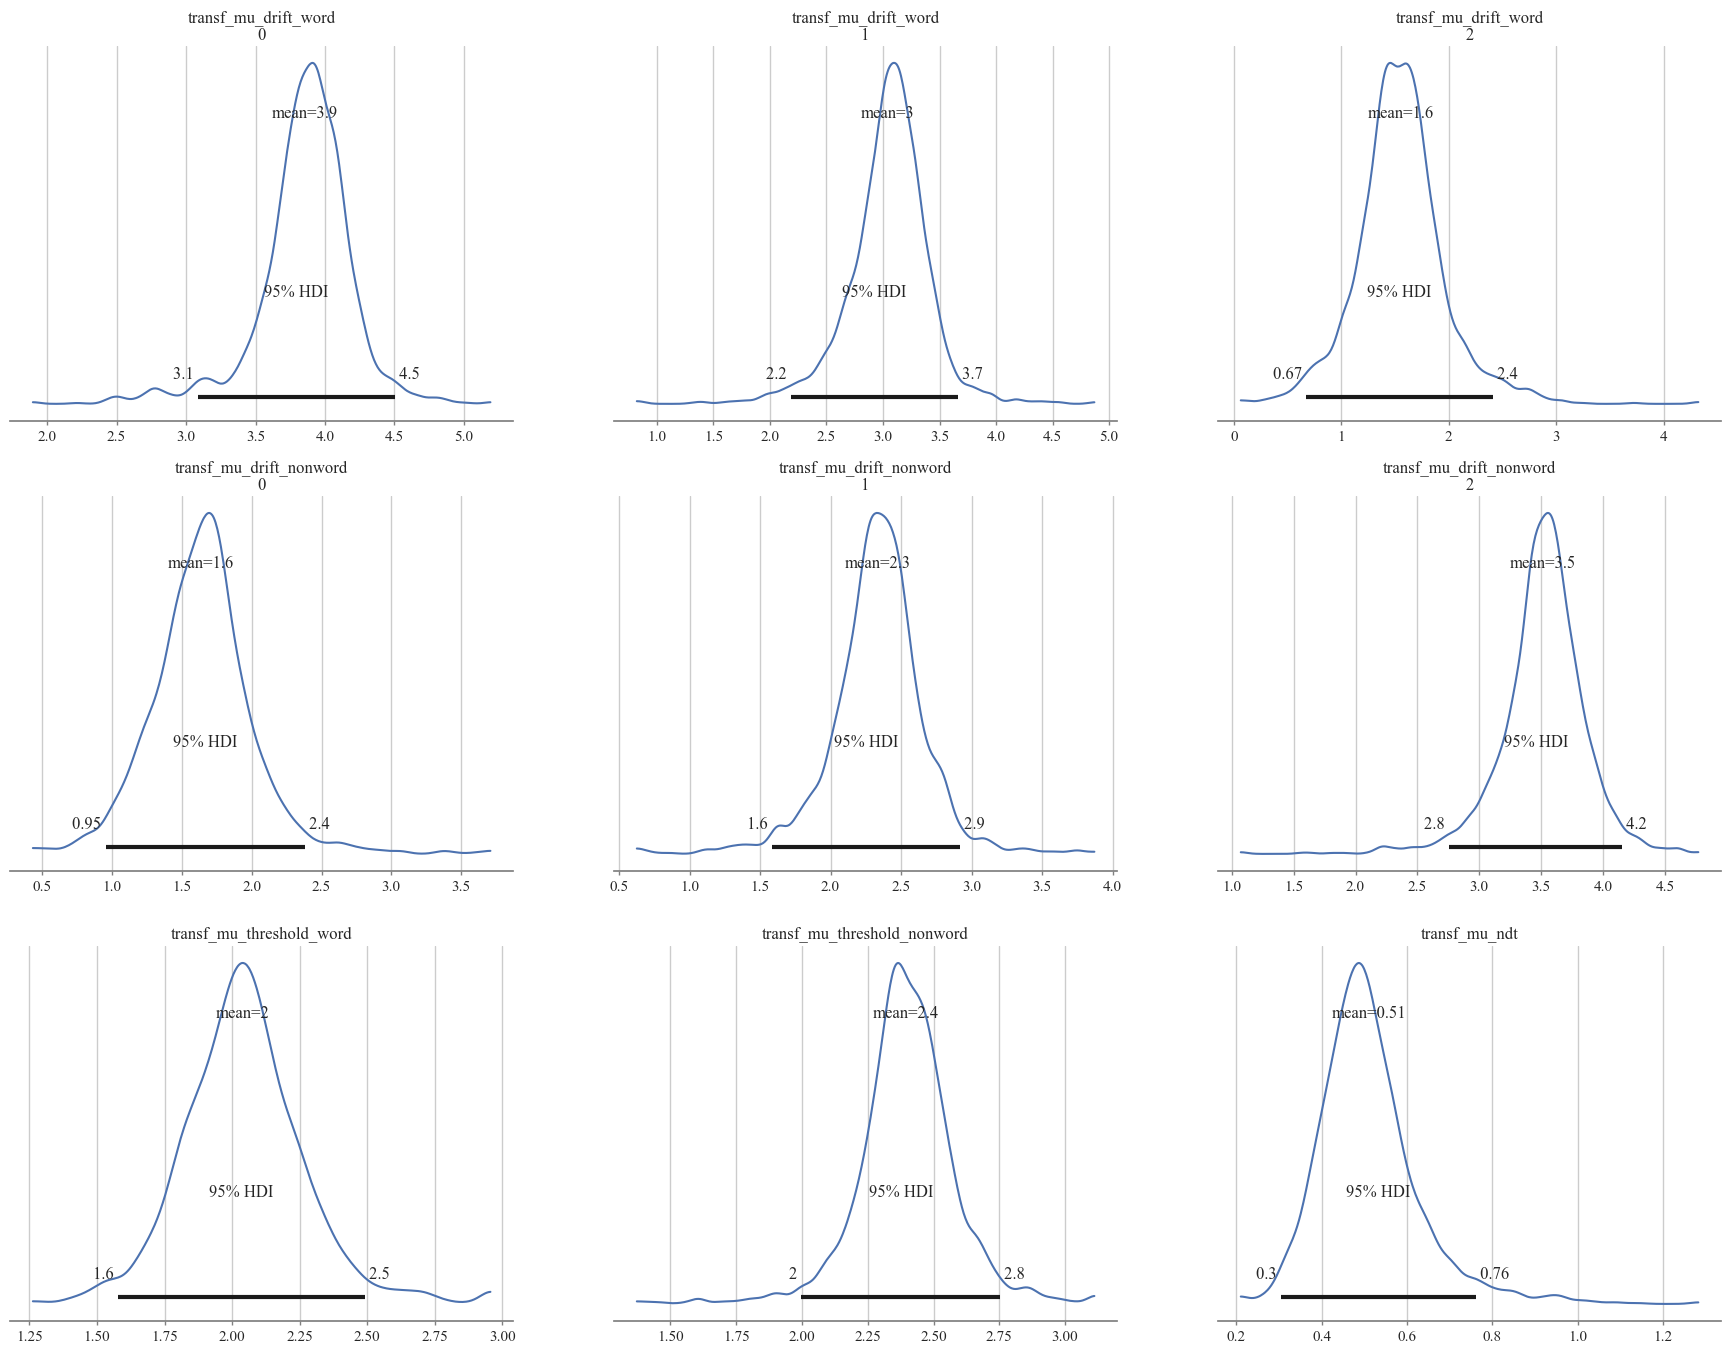

In [22]:
az.plot_posterior(fit, var_names=model_config["transf_params"], hdi_prob=.95);
plt.savefig(plots_path + "Parameters.pdf")

Loading model parameters for each trial

In [23]:
drift_word_t = fit.stan_variables()["drift_word_t"]
drift_nonword_t = fit.stan_variables()["drift_nonword_t"]
if model_config["model_name"] != "RDM":
    threshold_t_word = fit.stan_variables()["threshold_t_word"]
    threshold_t_nonword = fit.stan_variables()["threshold_t_nonword"]
else:
    threshold_t = fit.stan_variables()["threshold_t"]
ndt_t = fit.stan_variables()["ndt_t"]

#### Models mean parameters in different conditions

In [24]:
HF_condition_w = drift_word_t[:, behavioural_df["category"]=="HF"]
HF_condition_nw = drift_nonword_t[:, behavioural_df["category"]=="HF"]
LF_condition_w = drift_word_t[:, behavioural_df["category"]=="LF"]
LF_condition_nw = drift_nonword_t[:, behavioural_df["category"]=="LF"]
NW_condition_w = drift_word_t[:, behavioural_df["category"]=="NW"]
NW_condition_nw = drift_nonword_t[:, behavioural_df["category"]=="NW"]

In [25]:
print("HF words, word drift mean and std:")
print(np.mean(np.mean(HF_condition_w, axis=1)), np.std(np.mean(HF_condition_w, axis=1)))
print("HF words, nonword drift mean and std:")
print(np.mean(np.mean(HF_condition_nw, axis=1)), np.std(np.mean(HF_condition_nw, axis=1)))
print("LF words word drift mean and std:")
print(np.mean(np.mean(LF_condition_w, axis=1)), np.std(np.mean(LF_condition_w, axis=1)))
print("LF words nonword drift mean and std:")
print(np.mean(np.mean(LF_condition_nw, axis=1)), np.std(np.mean(LF_condition_nw, axis=1)))
print("NW words word drift mean and std:")
print(np.mean(np.mean(NW_condition_w, axis=1)), np.std(np.mean(NW_condition_w, axis=1)))
print("NW words nonword drift mean and std:")
print(np.mean(np.mean(NW_condition_nw, axis=1)), np.std(np.mean(NW_condition_nw, axis=1)))

HF words, word drift mean and std:
3.9358337810500004 0.1440583688302558
HF words, nonword drift mean and std:
1.6357553741733333 0.22084998705796097
LF words word drift mean and std:
3.1229342208064526 0.131204401385928
LF words nonword drift mean and std:
2.357948404153226 0.1516513574898362
NW words word drift mean and std:
1.5621508432603768 0.1371057489838721
NW words nonword drift mean and std:
3.586117970949686 0.11642474108951095


In [26]:
if model_config["model_name"] != "RDM":
    HF_condition_w = threshold_t_word[:, behavioural_df["category"]=="HF"]
    HF_condition_nw = threshold_t_nonword[:, behavioural_df["category"]=="HF"]
    LF_condition_w = threshold_t_word[:, behavioural_df["category"]=="LF"]
    LF_condition_nw = threshold_t_nonword[:, behavioural_df["category"]=="LF"]
    NW_condition_w = threshold_t_word[:, behavioural_df["category"]=="NW"]
    NW_condition_nw = threshold_t_nonword[:, behavioural_df["category"]=="NW"]
else:
    HF_condition = threshold_t[:, behavioural_df["category"]=="HF"]
    LF_condition = threshold_t[:, behavioural_df["category"]=="LF"]
    NW_condition = threshold_t[:, behavioural_df["category"]=="NW"]

In [27]:
if model_config["model_name"] != "RDM":
    print("HF words, word threshold mean and std:")
    print(np.mean(np.mean(HF_condition_w, axis=1)), np.std(np.mean(HF_condition_w, axis=1)))
    print("HF words, nonword threshold mean and std:")
    print(np.mean(np.mean(HF_condition_nw, axis=1)), np.std(np.mean(HF_condition_nw, axis=1)))
    print("LF words word threshold mean and std:")
    print(np.mean(np.mean(LF_condition_w, axis=1)), np.std(np.mean(LF_condition_w, axis=1)))
    print("LF words nonword threshold mean and std:")
    print(np.mean(np.mean(LF_condition_nw, axis=1)), np.std(np.mean(LF_condition_nw, axis=1)))
    print("NW words word threshold mean and std:")
    print(np.mean(np.mean(NW_condition_w, axis=1)), np.std(np.mean(NW_condition_w, axis=1)))
    print("NW words nonword threshold mean and std:")
    print(np.mean(np.mean(NW_condition_nw, axis=1)), np.std(np.mean(NW_condition_nw, axis=1)))
else:
    print("HF words, threshold mean and std:")
    print(np.mean(np.mean(HF_condition, axis=1)), np.std(np.mean(HF_condition, axis=1)))
    print("LF words, threshold mean and std:")
    print(np.mean(np.mean(LF_condition, axis=1)), np.std(np.mean(LF_condition, axis=1)))
    print("NW words, word threshold mean and std:")
    print(np.mean(np.mean(NW_condition, axis=1)), np.std(np.mean(NW_condition, axis=1)))

HF words, word threshold mean and std:
2.01808968035 0.10996124702906
HF words, nonword threshold mean and std:
2.410035521933333 0.11364836615509644
LF words word threshold mean and std:
2.039788390766129 0.10904795515705415
LF words nonword threshold mean and std:
2.4036686599999992 0.11193330396088517
NW words word threshold mean and std:
2.0351202014339624 0.10886796533596908
NW words nonword threshold mean and std:
2.4058281202515728 0.11199463735809112


In [28]:
HF_condition = ndt_t[:, behavioural_df["category"]=="HF"]
LF_condition = ndt_t[:, behavioural_df["category"]=="LF"]
NW_condition = ndt_t[:, behavioural_df["category"]=="NW"]

In [29]:
print("HF words ndt_t mean and std:")
print(np.mean(np.mean(HF_condition, axis=1)), np.std(np.mean(HF_condition, axis=1)))
print("LF words ndt_t mean and std:")
print(np.mean(np.mean(LF_condition, axis=1)), np.std(np.mean(LF_condition, axis=1)))
print("Non Words ndt_t mean and std:")
print(np.mean(np.mean(NW_condition, axis=1)), np.std(np.mean(NW_condition, axis=1)))

HF words ndt_t mean and std:
0.2240981463716667 0.0166238090627316
LF words ndt_t mean and std:
0.21903585395967748 0.016304343638145362
Non Words ndt_t mean and std:
0.21930716346918241 0.01629543471648444


## Calculating metrics

In [30]:
log_likelihood = fit.stan_variables()["log_lik"]
print(calculate_waic(log_likelihood))

{'lppd': -177.72070860564932, 'p_waic': 35.73422067425716, 'waic': 426.90985855981296, 'waic_se': 86.32886361947995}


## Simulating RDM with estimated parameters

Simulating RDM with estimated parameters

In [31]:
if model_config["model_name"] != "RDM":
    pp_rt, pp_response = random_rdm_2A(drift_word_t, drift_nonword_t, threshold_t_word, threshold_t_nonword, ndt_t, noise_constant=1, dt=0.001, max_rt=5)
else:
    pp_rt, pp_response = random_rdm_2A(drift_word_t, drift_nonword_t, threshold_t, threshold_t, ndt_t, noise_constant=1, dt=0.001, max_rt=5)

In [32]:
# Predicted Data
tmp1 = pd.DataFrame(pp_rt,
                    index=pd.Index(np.arange(1, len(pp_rt)+1), name="sample"),
                    columns=pd.MultiIndex.from_product((["rt"],
                                                        np.arange(pp_rt.shape[1])),
                                                        names=["variable", "trial"]))
tmp2 = pd.DataFrame(pp_response,
                    index=pd.Index(np.arange(1, len(pp_response)+1), name="sample"),
                    columns=pd.MultiIndex.from_product((["response"],
                                                        np.arange(pp_response.shape[1])),
                                                               names=["variable", "trial"]))
predictedData = pd.concat((tmp1, tmp2), axis=1)

## RT Quantiles Posterior Predictions Checks

In [33]:
quantiles = [.1, .3, .5, .7, .9]

### All Trials

In [34]:
exp_all_trials, pred_all_trials = get_dfs(behavioural_df, predictedData)

In [35]:
all_quantiles_ex = exp_all_trials["rt"].quantile(quantiles)
all_quantiles_pred = pred_all_trials.quantile(quantiles, axis=1).T
all_predicted_bci = np.array([bci(all_quantiles_pred[x]) for x in quantiles])

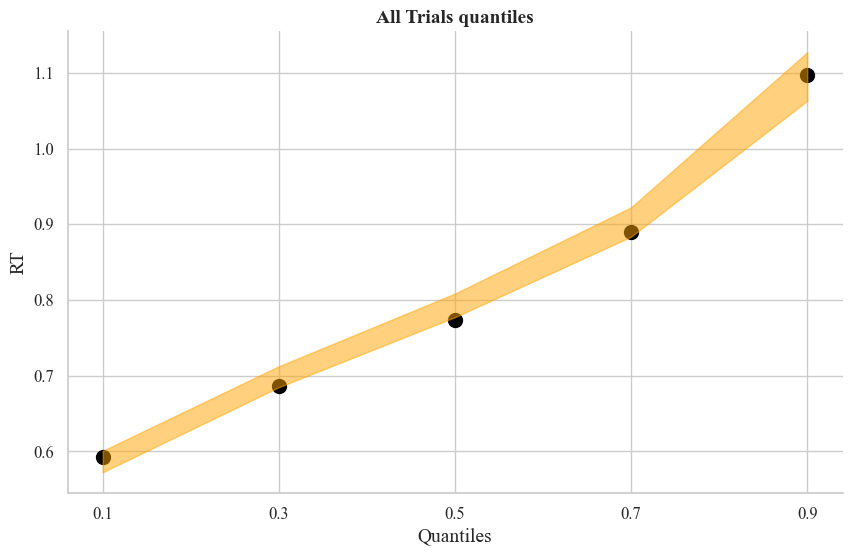

In [36]:
fig, ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

ax.set_title("All Trials quantiles", fontweight="bold", size=14)
ax.scatter(quantiles, all_quantiles_ex, color="black", s=100)

ax.fill_between(quantiles,
                all_predicted_bci[:, 0],
                all_predicted_bci[:, 1],
                all_predicted_bci[:, 0] < all_predicted_bci[:, 1],  color = "orange", alpha=0.5)

ax.set_xlabel("Quantiles", fontsize=14)
ax.set_xticks(quantiles)
ax.set_xticklabels(quantiles)
ax.set_ylabel("RT", fontsize=14)
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12) 

sns.despine()
plt.savefig(plots_path + "PPC-Quantiles-All Trials.pdf")

### All Trials (word response vs non-word response)

In [37]:
exp_word_resp_all, pred_word_resp_all = get_dfs(behavioural_df, predictedData,
                                                response=1)
exp_nonword_resp_all, pred_nonword_resp_all = get_dfs(behavioural_df, predictedData,
                                                      response=0)

In [38]:
word_quantiles_ex = exp_word_resp_all["rt"].quantile(quantiles)
nonword_quantiles_ex = exp_nonword_resp_all["rt"].quantile(quantiles)

word_quantiles_pred = pred_word_resp_all.quantile(quantiles, axis=1).T
nonword_quantiles_pred = pred_nonword_resp_all.quantile(quantiles, axis=1).T

word_predicted_bci = np.array([bci(word_quantiles_pred[x]) for x in quantiles])
nonword_predicted_bci = np.array([bci(nonword_quantiles_pred[x]) for x in quantiles])

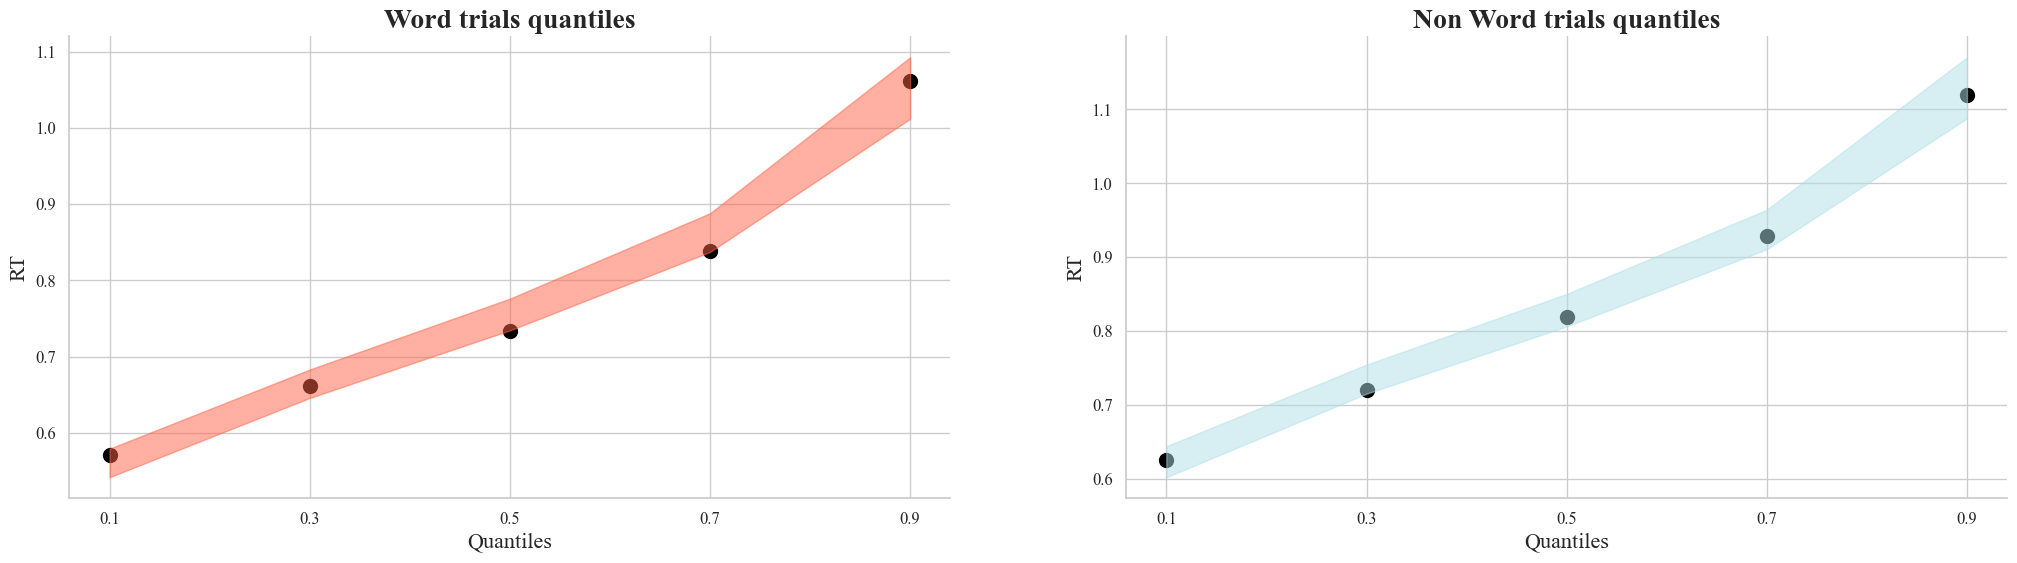

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(25,6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0].set_title("Word trials quantiles", fontweight="bold", size=20)
axes[1].set_title("Non Word trials quantiles", fontweight="bold", size=20)

axes[0].scatter(quantiles, word_quantiles_ex, color="black", s=100)
axes[1].scatter(quantiles, nonword_quantiles_ex, color="black", s=100)

axes[0].fill_between(quantiles,
                word_predicted_bci[:, 0],
                word_predicted_bci[:, 1],
                word_predicted_bci[:, 0] < word_predicted_bci[:, 1],  color = "tomato", alpha=0.5)

axes[1].fill_between(quantiles,
                nonword_predicted_bci[:, 0],
                nonword_predicted_bci[:, 1],
                nonword_predicted_bci[:, 0] < nonword_predicted_bci[:, 1],  color = "powderblue", alpha=0.5)

for ax in axes:
        ax.set_xlabel("Quantiles", fontsize=16)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel("RT", fontsize=16)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(12) 

sns.despine()
plt.savefig(plots_path + "PPC-Quantiles-All Trials-Word vs Nonword.pdf")

### All trials (Correct Choice vs Incorrect Choice) 

In [40]:
exp_cor_choice_all, _ = get_dfs(behavioural_df, predictedData,
                                accuracy=1)
exp_incor_resp_all, _ = get_dfs(behavioural_df, predictedData,
                                accuracy=0)
pred_cor_choice_all = predictedData["rt"][predictedData["response"]==behavioural_df["label"]]
pred_incor_choice_all = predictedData["rt"][predictedData["response"]!=behavioural_df["label"]]

In [41]:
cor_quantiles_ex = exp_cor_choice_all["rt"].quantile(quantiles)
incor_quantiles_ex = exp_incor_resp_all["rt"].quantile(quantiles)

cor_quantiles_pred = pred_cor_choice_all.quantile(quantiles, axis=1).T
incor_quantiles_pred = pred_incor_choice_all.quantile(quantiles, axis=1).T

cor_predicted_bci = np.array([bci(cor_quantiles_pred[x]) for x in quantiles])
incor_predicted_bci = np.array([bci(incor_quantiles_pred[x]) for x in quantiles])

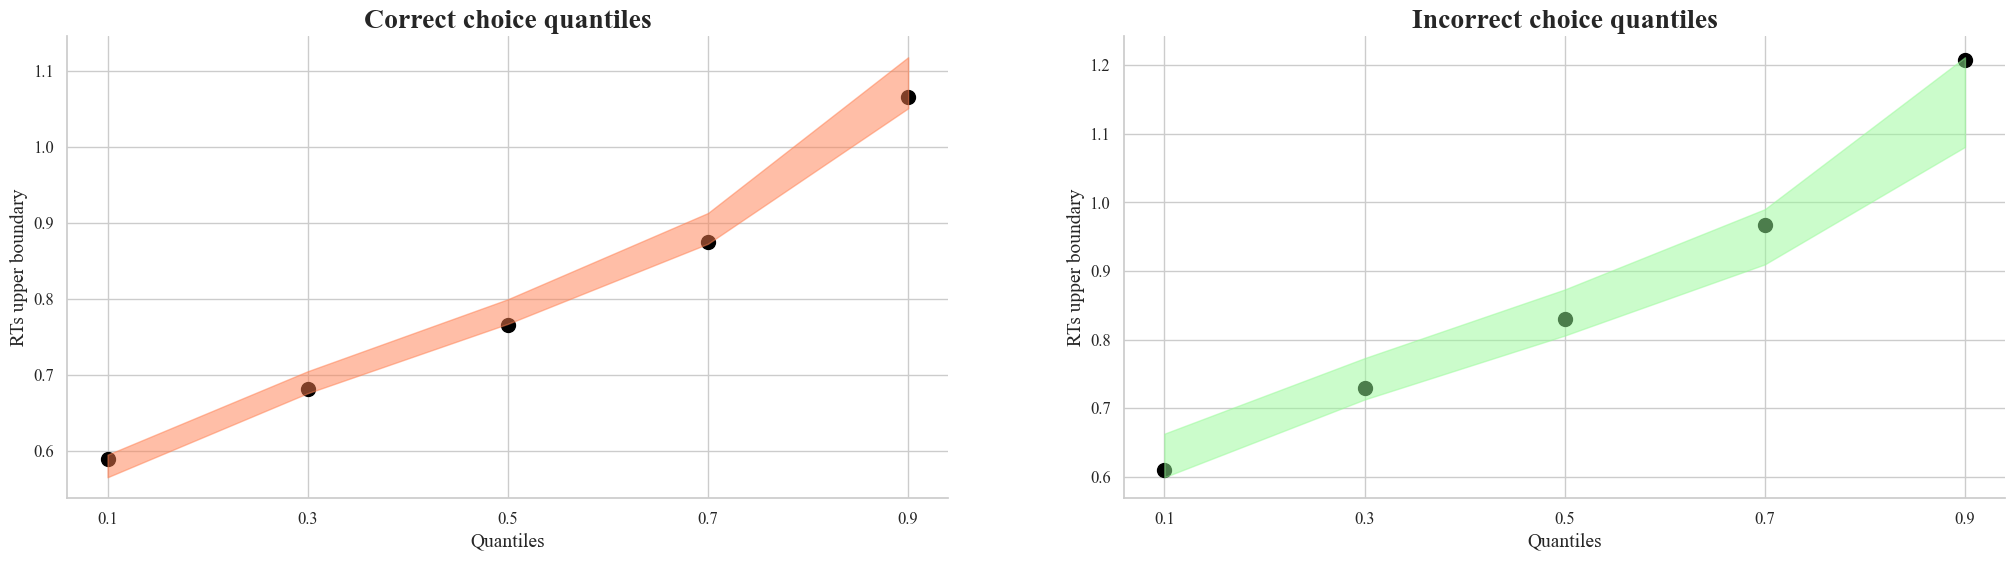

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(25,6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0].set_title("Correct choice quantiles", fontweight="bold", size=20)
axes[1].set_title("Incorrect choice quantiles", fontweight="bold", size=20)

axes[0].scatter(quantiles, cor_quantiles_ex, color="black", s=100)
axes[1].scatter(quantiles, incor_quantiles_ex, color="black", s=100)

axes[0].fill_between(quantiles,
                cor_predicted_bci[:, 0],
                cor_predicted_bci[:, 1],
                cor_predicted_bci[:, 0] < cor_predicted_bci[:, 1],  color = "coral", alpha=0.5)

axes[1].fill_between(quantiles,
                incor_predicted_bci[:, 0],
                incor_predicted_bci[:, 1],
                incor_predicted_bci[:, 0] < incor_predicted_bci[:, 1],  color = "palegreen", alpha=0.5)

for ax in axes:
        ax.set_xlabel("Quantiles", fontsize=14)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel("RTs upper boundary", fontsize=14)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(12) 

sns.despine()
plt.savefig(plots_path + "PPC-Quantiles-All Trials-Correct vs Incorrect.pdf")

### Conditional (HF, LF, NW trials)

In [43]:
exp_HF_trials, pred_HF_trials = get_dfs(behavioural_df, predictedData,
                                        category="HF")
exp_LF_trials, pred_LF_trials = get_dfs(behavioural_df, predictedData,
                                        category="LF")
exp_NW_trials, pred_NW_trials = get_dfs(behavioural_df, predictedData,
                                        category="NW")

In [44]:
# experiment Data quantile
HF_quantile_ex = exp_HF_trials["rt"].quantile(quantiles)
LF_quantile_ex = exp_LF_trials["rt"].quantile(quantiles)
NW_quantile_ex = exp_NW_trials["rt"].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_quantile_pred = pred_HF_trials.quantile(quantiles, axis=1).T
LF_quantile_pred = pred_LF_trials.quantile(quantiles, axis=1).T
NW_quantile_pred = pred_NW_trials.quantile(quantiles, axis=1).T

# predicted data quantiles bci
HF_predicted_bci = np.array([bci(HF_quantile_pred[x]) for x in quantiles])
LF_predicted_bci = np.array([bci(LF_quantile_pred[x]) for x in quantiles])
NW_predicted_bci = np.array([bci(NW_quantile_pred[x]) for x in quantiles])

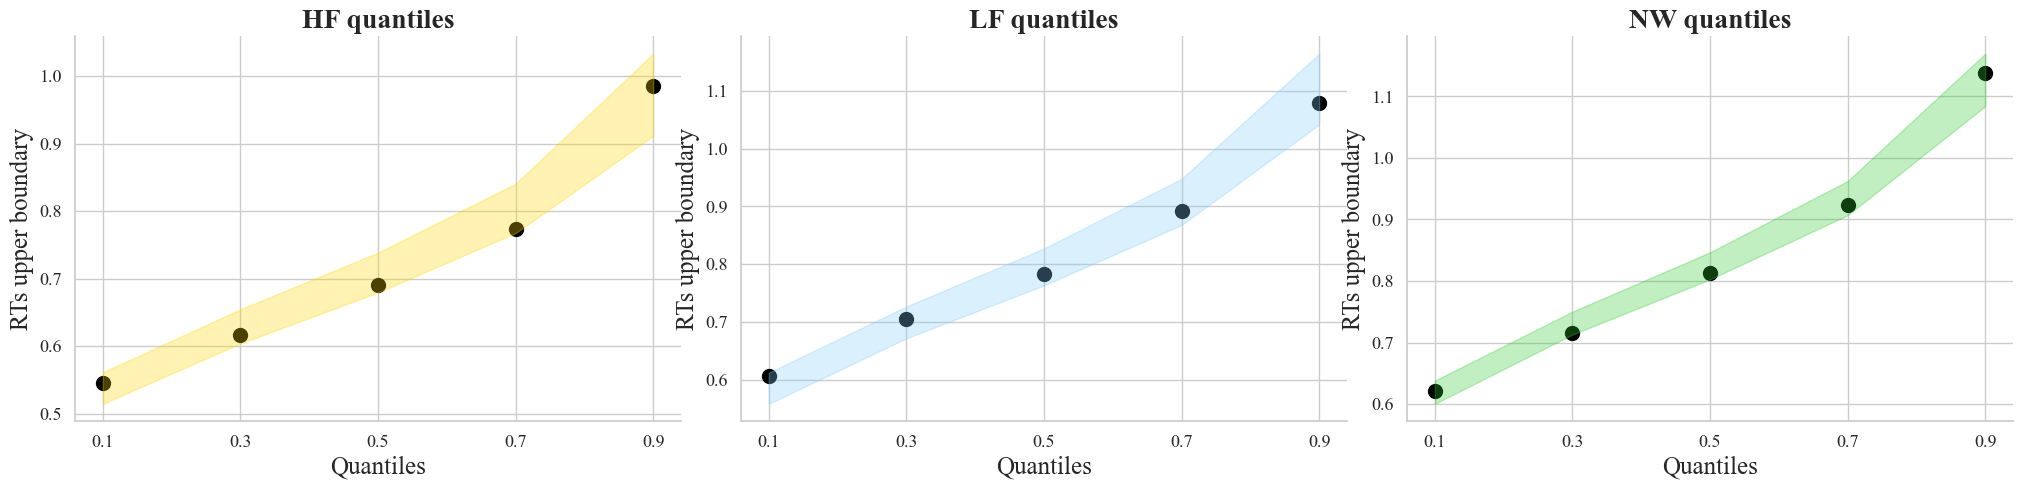

In [45]:
fig, axes = plt.subplots(1,3 , figsize=(25,5))
plt.subplots_adjust(wspace=0.1, hspace=0.5)

axes[0].set_title("HF quantiles", fontweight="bold", size=20)
axes[1].set_title("LF quantiles", fontweight="bold", size=20)
axes[2].set_title("NW quantiles", fontweight="bold", size=20)

axes[0].scatter(quantiles, HF_quantile_ex, color="black", s=100)
axes[1].scatter(quantiles, LF_quantile_ex, color="black", s=100)
axes[2].scatter(quantiles, NW_quantile_ex, color="black", s=100)

axes[0].fill_between(quantiles,
                HF_predicted_bci[:, 0],
                HF_predicted_bci[:, 1],
                HF_predicted_bci[:, 0] < HF_predicted_bci[:, 1],  color = "gold", alpha=0.3)

axes[1].fill_between(quantiles,
                LF_predicted_bci[:, 0],
                LF_predicted_bci[:, 1],
                LF_predicted_bci[:, 0] < LF_predicted_bci[:, 1],  color = "lightskyblue", alpha=0.3)

axes[2].fill_between(quantiles,
                NW_predicted_bci[:, 0],
                NW_predicted_bci[:, 1],
                NW_predicted_bci[:, 0] < NW_predicted_bci[:, 1],  color = "limegreen", alpha=0.3)


for ax in axes:
        ax.set_xlabel("Quantiles", fontsize=18)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel("RTs upper boundary", fontsize=18)
        for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(13)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(13) 

sns.despine()
plt.savefig(plots_path + "PPC-Quantiles-Conditional.pdf")

### Conditional (HF, LF, NW trials) for word response and nonword response

In [46]:
exp_word_resp_HF, pred_word_resp_HF = get_dfs(behavioural_df, predictedData,
                                              category="HF", response=1)
exp_word_resp_LF, pred_word_resp_LF = get_dfs(behavioural_df, predictedData,
                                              category="LF", response=1)
exp_word_resp_NW, pred_word_resp_NW = get_dfs(behavioural_df, predictedData,
                                              category="NW", response=1)

exp_nonword_resp_HF, pred_nonword_resp_HF = get_dfs(behavioural_df, predictedData,
                                                    category="HF", response=0)
exp_nonword_resp_LF, pred_nonword_resp_LF = get_dfs(behavioural_df, predictedData,
                                                    category="LF", response=0)
exp_nonword_resp_NW, pred_nonword_resp_NW = get_dfs(behavioural_df, predictedData,
                                                    category="NW", response=0)

In [47]:
# experiment Data quantile
HF_word_quantile_ex = exp_word_resp_HF["rt"].quantile(quantiles)
LF_word_quantile_ex = exp_word_resp_LF["rt"].quantile(quantiles)
NW_word_quantile_ex = exp_word_resp_NW["rt"].quantile(quantiles)

HF_nonword_quantile_ex = exp_nonword_resp_HF["rt"].quantile(quantiles)
LF_nonword_quantile_ex = exp_nonword_resp_LF["rt"].quantile(quantiles)
NW_nonword_quantile_ex = exp_nonword_resp_NW["rt"].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_word_quantile_pred = pred_word_resp_HF.quantile(quantiles, axis=1).T
LF_word_quantile_pred = pred_word_resp_LF.quantile(quantiles, axis=1).T
NW_word_quantile_pred = pred_word_resp_NW.quantile(quantiles, axis=1).T

HF_nonword_quantile_pred = pred_nonword_resp_HF.quantile(quantiles, axis=1).T
LF_nonword_quantile_pred = pred_nonword_resp_LF.quantile(quantiles, axis=1).T
NW_nonword_quantile_pred = pred_nonword_resp_NW.quantile(quantiles, axis=1).T


# predicted data quantiles bci
HF_word_predicted_bci = np.array([bci(HF_word_quantile_pred[x]) for x in quantiles])
LF_word_predicted_bci = np.array([bci(LF_word_quantile_pred[x]) for x in quantiles])
NW_word_predicted_bci = np.array([bci(NW_word_quantile_pred[x]) for x in quantiles])

HF_nonword_predicted_bci = np.array([bci(HF_nonword_quantile_pred[x]) for x in quantiles])
LF_nonword_predicted_bci = np.array([bci(LF_nonword_quantile_pred[x]) for x in quantiles])
NW_nonword_predicted_bci = np.array([bci(NW_nonword_quantile_pred[x]) for x in quantiles])

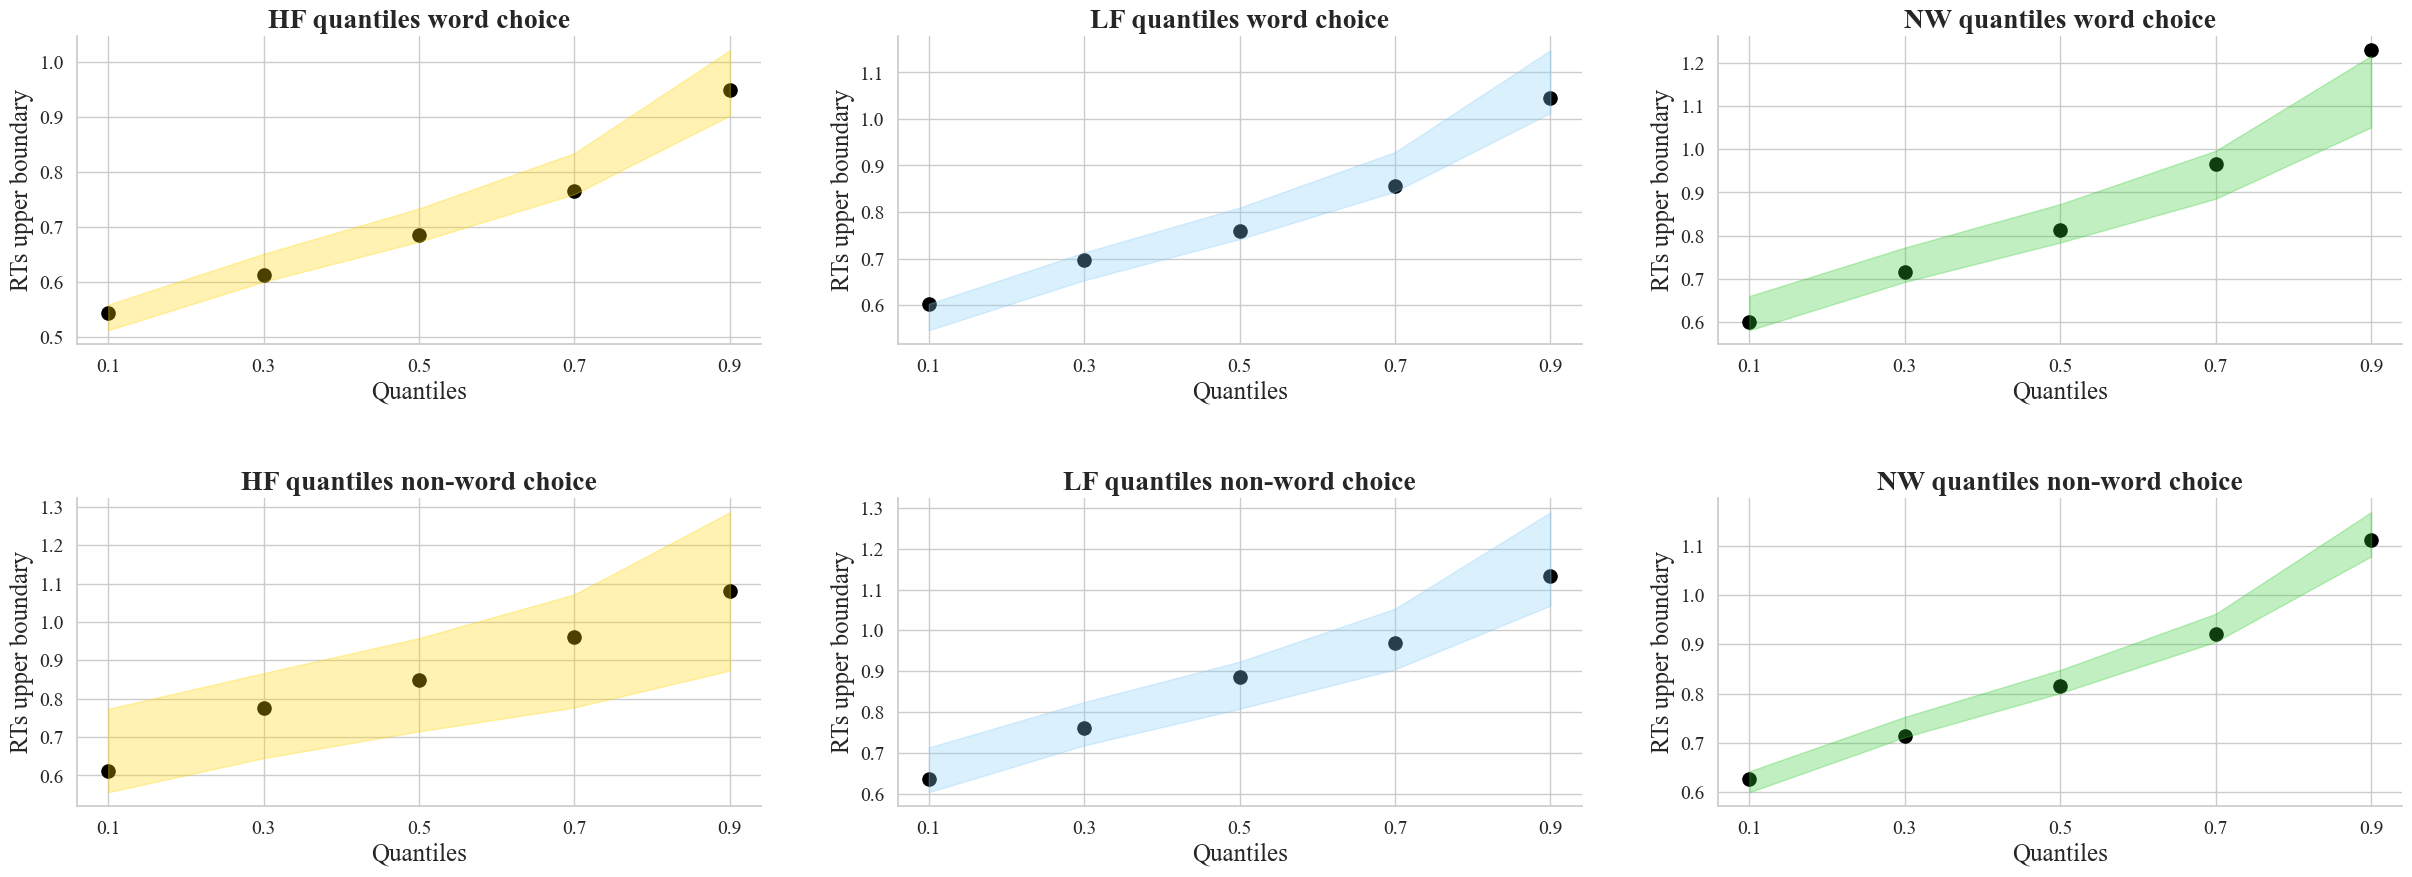

In [48]:
fig, axes = plt.subplots(2,3 , figsize=(30,10))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes[0][0].set_title("HF quantiles word choice", fontweight="bold", size=20)
axes[0][1].set_title("LF quantiles word choice", fontweight="bold", size=20)
axes[0][2].set_title("NW quantiles word choice", fontweight="bold", size=20)

axes[1][0].set_title("HF quantiles non-word choice", fontweight="bold", size=20)
axes[1][1].set_title("LF quantiles non-word choice", fontweight="bold", size=20)
axes[1][2].set_title("NW quantiles non-word choice", fontweight="bold", size=20)

axes[0][0].scatter(quantiles, HF_word_quantile_ex, color="black", s=90)
axes[0][1].scatter(quantiles, LF_word_quantile_ex, color="black", s=90)
axes[0][2].scatter(quantiles, NW_word_quantile_ex, color="black", s=90)

axes[1][0].scatter(quantiles, HF_nonword_quantile_ex, color="black", s=90)
axes[1][1].scatter(quantiles, LF_nonword_quantile_ex, color="black", s=90)
axes[1][2].scatter(quantiles, NW_nonword_quantile_ex, color="black", s=90)


axes[0][0].fill_between(quantiles,
                HF_word_predicted_bci[:, 0],
                HF_word_predicted_bci[:, 1],
                HF_word_predicted_bci[:, 0] < HF_word_predicted_bci[:, 1],  color = "gold", alpha=0.3)

axes[0][1].fill_between(quantiles,
                LF_word_predicted_bci[:, 0],
                LF_word_predicted_bci[:, 1],
                LF_word_predicted_bci[:, 0] < LF_word_predicted_bci[:, 1],  color = "lightskyblue", alpha=0.3)

axes[0][2].fill_between(quantiles,
                NW_word_predicted_bci[:, 0],
                NW_word_predicted_bci[:, 1],
                NW_word_predicted_bci[:, 0] < NW_word_predicted_bci[:, 1],  color = "limegreen", alpha=0.3)


axes[1][0].fill_between(quantiles,
                HF_nonword_predicted_bci[:, 0],
                HF_nonword_predicted_bci[:, 1],
                HF_nonword_predicted_bci[:, 0] < HF_nonword_predicted_bci[:, 1],  color = "gold", alpha=0.3)

axes[1][1].fill_between(quantiles,
                LF_nonword_predicted_bci[:, 0],
                LF_nonword_predicted_bci[:, 1],
                LF_nonword_predicted_bci[:, 0] < LF_nonword_predicted_bci[:, 1],  color = "lightskyblue", alpha=0.3)

axes[1][2].fill_between(quantiles,
                NW_nonword_predicted_bci[:, 0],
                NW_nonword_predicted_bci[:, 1],
                NW_nonword_predicted_bci[:, 0] < NW_nonword_predicted_bci[:, 1],  color = "limegreen", alpha=0.3)


for ax_d1 in axes:
    for ax in ax_d1:
        ax.set_xlabel("Quantiles", fontsize=18)
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel("RTs upper boundary", fontsize=18)
        for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(14)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(14) 

sns.despine()
plt.savefig(plots_path + "PPC-Quantiles-Conditional-Word vs Nonword.pdf")

## Mean Accuracy and RT Posterior Prediction Checks


### All trials

In [49]:
exp_all_trials_rt, pred_all_trials_rt = get_dfs(behavioural_df, predictedData)
exp_all_trials_resp, pred_all_trials_resp = get_dfs(behavioural_df, predictedData,
                                                    pred_df_type="response")

In [50]:
all_data_rt_mean = exp_all_trials_rt["rt"].mean()
all_pred_rt_mean = pred_all_trials_rt.mean(axis=1)

all_data_resp_mean = exp_all_trials_resp["response"].mean()
all_pred_resp_mean = pred_all_trials_resp.mean(axis=1)

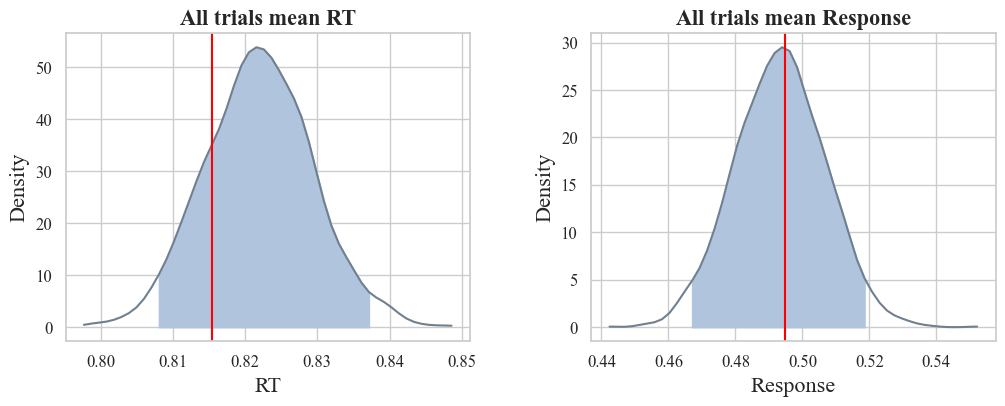

In [51]:
fig, axes = plt.subplots(1,2 , figsize=(12, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0].set_title("All trials mean RT", fontweight="bold", size=16)
axes[1].set_title("All trials mean Response", fontweight="bold", size=16)

plot_mean_posterior(all_pred_rt_mean, all_data_rt_mean, axes[0])
plot_mean_posterior(all_pred_resp_mean, all_data_resp_mean, axes[1])

axes[0].set_xlabel("RT", fontsize=16)
axes[1].set_xlabel("Response", fontsize=16)

for ax in axes:
        ax.set_ylabel("Density", fontsize=16)
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(12)
            
plt.savefig(plots_path + "PPC-Mean Accuracy and RT-All trials.pdf")

### All Trials (correct choice vs incorrect choice)

In [52]:
exp_cor_all_trials_rt, pred_cor_all_trials_rt = get_dfs(behavioural_df, predictedData,
                                                        accuracy=1)
exp_incor_all_trials_rt, pred_incor_all_trials_rt = get_dfs(behavioural_df, predictedData,
                                                            accuracy=0)

exp_cor_all_trials_resp, pred_cor_all_trials_resp = get_dfs(behavioural_df, predictedData,
                                                            accuracy=1, pred_df_type="response")
exp_incor_all_trials_resp, pred_incor_all_trials_resp = get_dfs(behavioural_df, predictedData,
                                                                accuracy=0, pred_df_type="response")

In [53]:
all_trials_cor_rt_mean = exp_cor_all_trials_rt["rt"].mean()
all_pred_cor_rt_mean = pred_cor_all_trials_rt.mean(axis=1)

all_trials_incor_rt_mean = exp_incor_all_trials_rt["rt"].mean()
all_pred_incor_rt_mean = pred_incor_all_trials_rt.mean(axis=1)


all_data_cor_resp_mean = exp_cor_all_trials_resp["response"].mean()
all_pred_cor_resp_mean = pred_cor_all_trials_resp.mean(axis=1)

all_data_incor_resp_mean = exp_incor_all_trials_resp["response"].mean()
all_pred_incor_resp_mean = pred_incor_all_trials_resp.mean(axis=1)

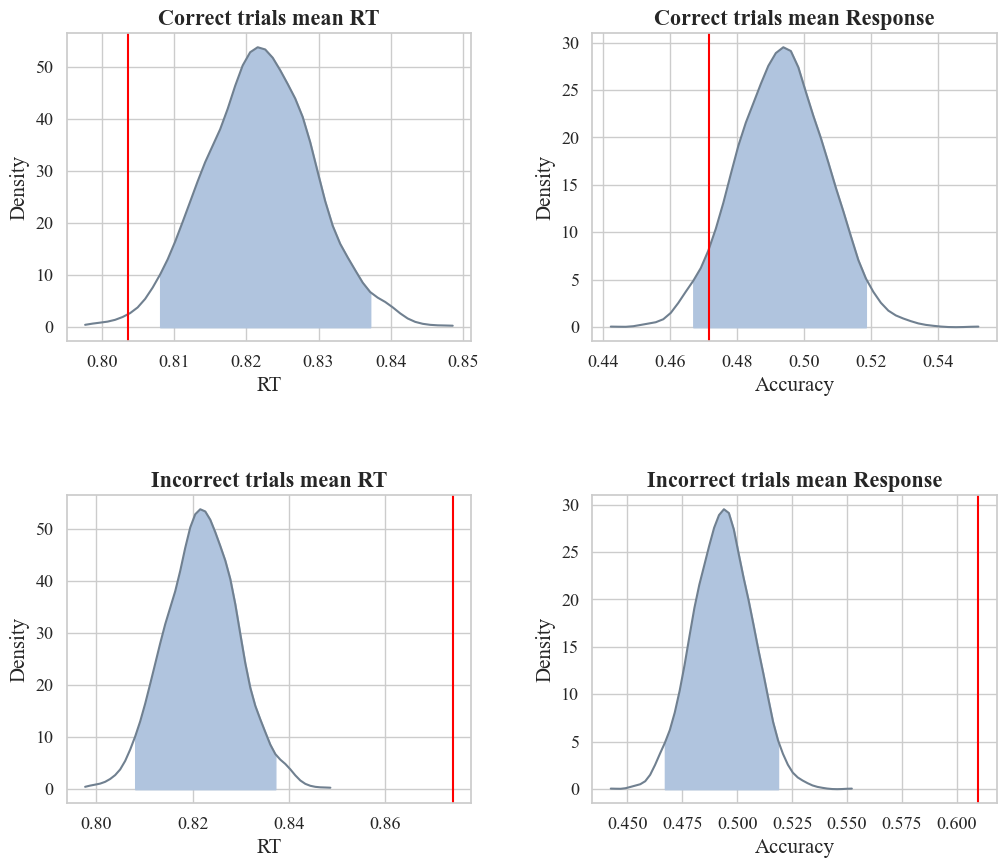

In [54]:
fig, axes = plt.subplots(2,2 , figsize=(12,10))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0][0].set_title("Correct trials mean RT", fontweight="bold", size=16)
axes[0][1].set_title("Correct trials mean Response", fontweight="bold", size=16)
axes[1][0].set_title("Incorrect trials mean RT", fontweight="bold", size=16)
axes[1][1].set_title("Incorrect trials mean Response", fontweight="bold", size=16)

plot_mean_posterior(all_pred_cor_rt_mean, all_trials_cor_rt_mean, axes[0][0])
plot_mean_posterior(all_pred_cor_resp_mean, all_data_cor_resp_mean, axes[0][1])

plot_mean_posterior(all_pred_incor_rt_mean, all_trials_incor_rt_mean, axes[1][0])
plot_mean_posterior(all_pred_incor_resp_mean, all_data_incor_resp_mean, axes[1][1])

for ax in axes:
        ax[0].set_xlabel("RT", fontsize=15)
        ax[1].set_xlabel("Accuracy", fontsize=15)
        ax[0].set_ylabel("Density", fontsize=15)
        ax[1].set_ylabel("Density", fontsize=15)
        for tick in ax[0].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[0].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13) 

plt.savefig(plots_path + "PPC-Mean Accuracy and RT-All trials-Correct vs Incorrect.pdf")

### Conditional (HF, LF, NW trials) 

In [55]:
exp_HF_trials_rt, pred_HF_trials_rt = get_dfs(behavioural_df, predictedData,
                                              category="HF")
exp_LF_trials_rt, pred_LF_trials_rt = get_dfs(behavioural_df, predictedData,
                                              category="LF")
exp_NW_trials_rt, pred_NW_trials_rt = get_dfs(behavioural_df, predictedData,
                                              category="NW")

exp_HF_trials_resp, pred_HF_trials_resp = get_dfs(behavioural_df, predictedData,
                                                  category="HF", pred_df_type="response")
exp_LF_trials_resp, pred_LF_trials_resp = get_dfs(behavioural_df, predictedData,
                                                  category="LF", pred_df_type="response")
exp_NW_trials_resp, pred_NW_trials_resp = get_dfs(behavioural_df, predictedData,
                                                  category="NW", pred_df_type="response")

In [56]:
HF_data_rt_mean = exp_HF_trials_rt["rt"].mean()
LF_data_rt_mean = exp_LF_trials_rt["rt"].mean()
NW_data_rt_mean = exp_NW_trials_rt["rt"].mean()

HF_pred_rt_mean = pred_HF_trials_rt.mean(axis=1)
LF_pred_rt_mean = pred_LF_trials_rt.mean(axis=1)
NW_pred_rt_mean = pred_NW_trials_rt.mean(axis=1)


HF_data_resp_mean = exp_HF_trials_resp["response"].mean()
LF_data_resp_mean = exp_LF_trials_resp["response"].mean()
NW_data_resp_mean = exp_NW_trials_resp["response"].mean()

HF_pred_resp_mean = pred_HF_trials_resp.mean(axis=1)
LF_pred_resp_mean = pred_LF_trials_resp.mean(axis=1)
NW_pred_resp_mean = pred_NW_trials_resp.mean(axis=1)


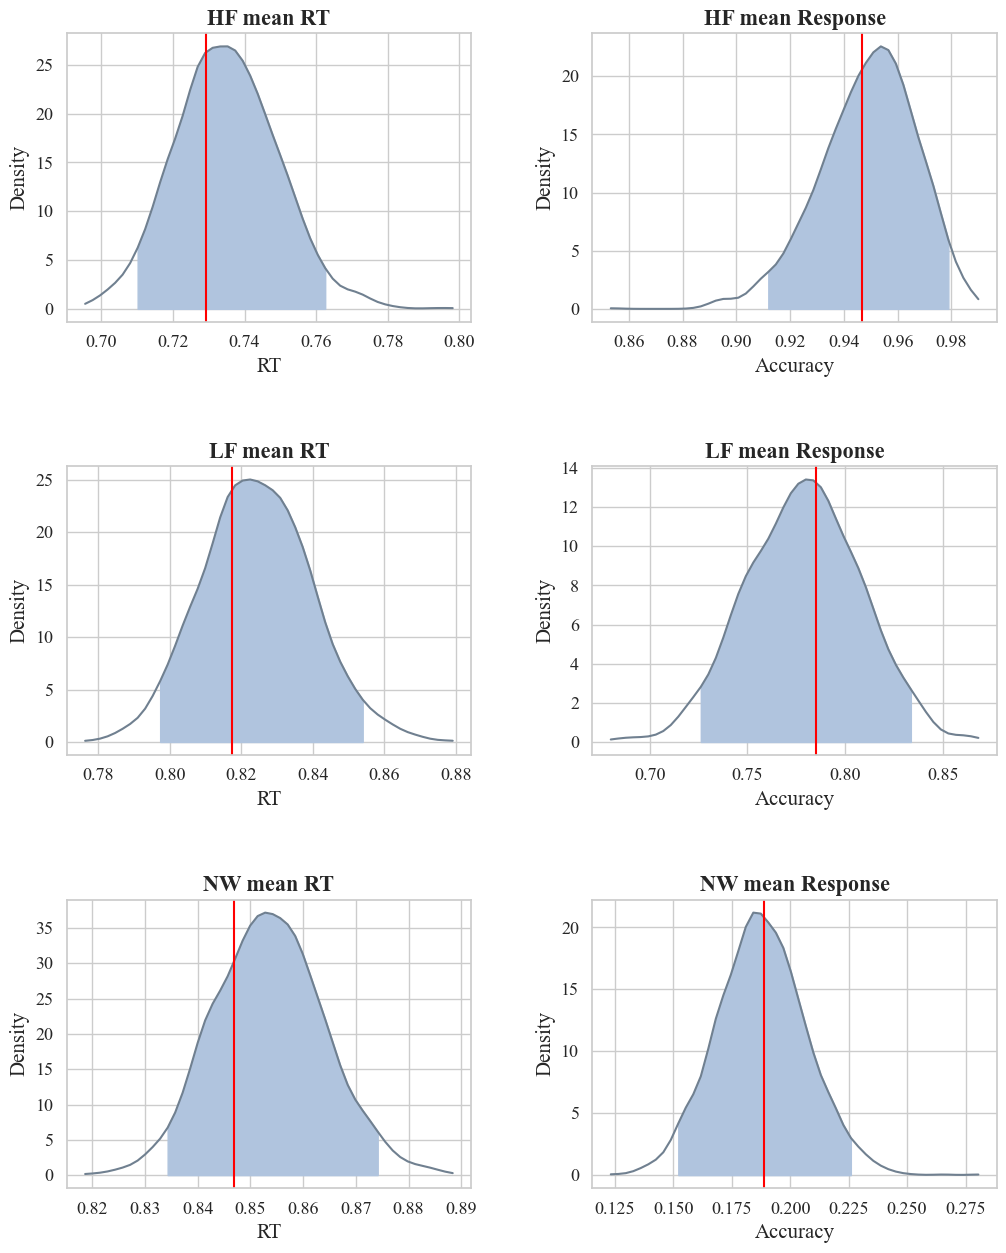

In [57]:
fig, axes = plt.subplots(3,2 , figsize=(12,15))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

axes[0][0].set_title("HF mean RT", fontweight="bold", size=16)
axes[0][1].set_title("HF mean Response", fontweight="bold", size=16)
axes[1][0].set_title("LF mean RT", fontweight="bold", size=16)
axes[1][1].set_title("LF mean Response", fontweight="bold", size=16)
axes[2][0].set_title("NW mean RT", fontweight="bold", size=16)
axes[2][1].set_title("NW mean Response", fontweight="bold", size=16)

plot_mean_posterior(HF_pred_rt_mean, HF_data_rt_mean, axes[0][0])
plot_mean_posterior(HF_pred_resp_mean, HF_data_resp_mean, axes[0][1])

plot_mean_posterior(LF_pred_rt_mean, LF_data_rt_mean, axes[1][0])
plot_mean_posterior(LF_pred_resp_mean, LF_data_resp_mean, axes[1][1])

plot_mean_posterior(NW_pred_rt_mean, NW_data_rt_mean, axes[2][0])
plot_mean_posterior(NW_pred_resp_mean, NW_data_resp_mean, axes[2][1])

for ax in axes:
        ax[0].set_xlabel("RT", fontsize=15)
        ax[1].set_xlabel("Accuracy", fontsize=15)
        ax[0].set_ylabel("Density", fontsize=15)
        ax[1].set_ylabel("Density", fontsize=15)
        for tick in ax[0].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[0].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].xaxis.get_major_ticks():
            tick.label1.set_fontsize(13)
        for tick in ax[1].yaxis.get_major_ticks():
            tick.label1.set_fontsize(13) 

plt.savefig(plots_path + "PPC-Mean Accuracy and RT-Conditional.pdf")